Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/tmp/ipykernel_3303/891934424.py:128: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/workspace/DEMO/Upsample-Anything-A-Simple-and-Hard-to-Beat-Baseline-for-Feature-Upsampling/upsample_anything.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)
/workspace/DEMO/Upsample-Anything-A-Simple-and-Hard-to-Beat-Baseline-for-Feature-Upsampling/upsample_anything.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP, dtype=AMP_DTYPE):
/workspace/DEMO/Upsample-Anything-A-Simple-and-Hard-to-Beat-Baseline-for-Feature-Upsampling/upsample_anything.py:14

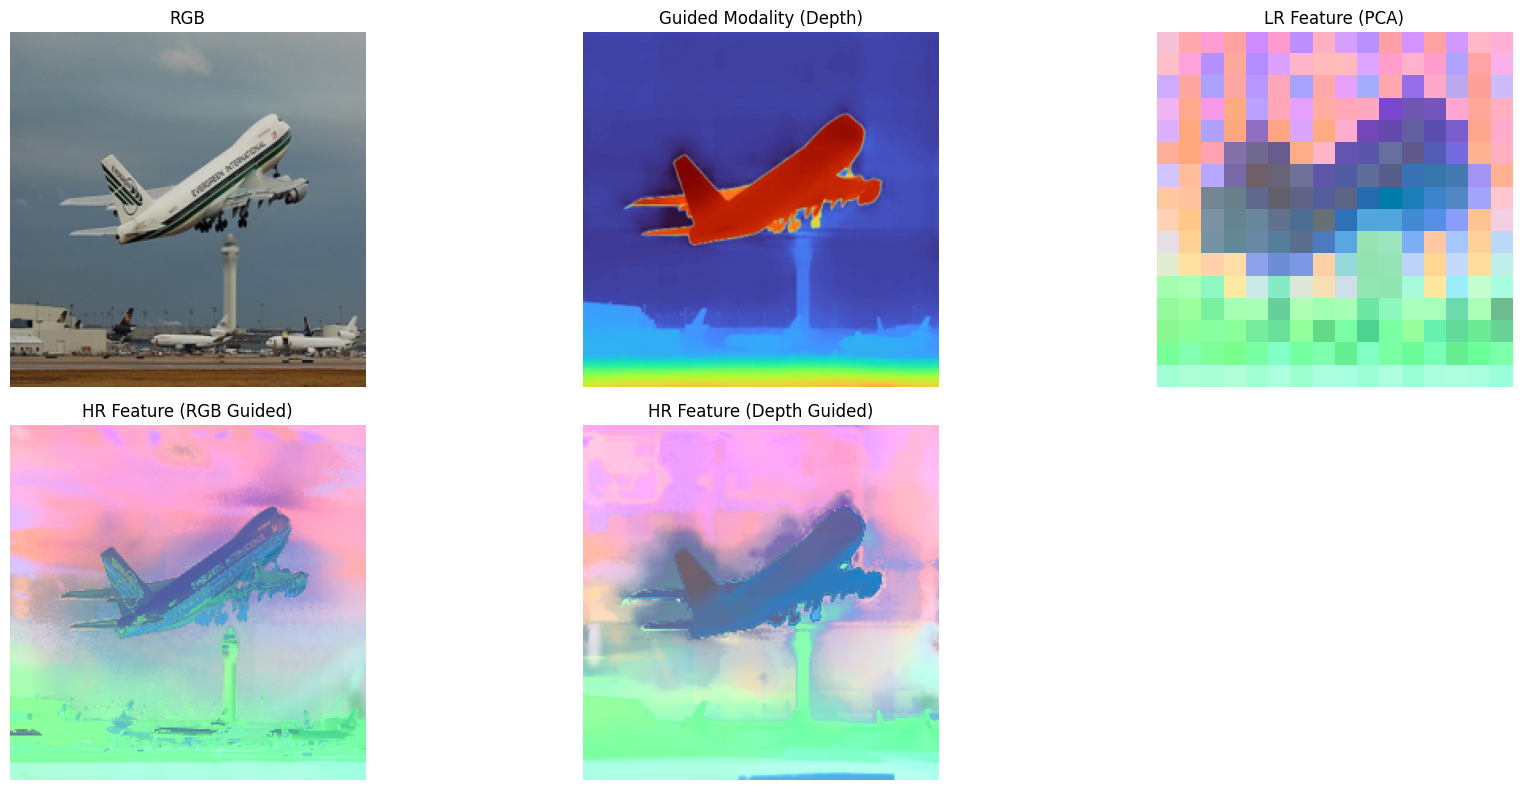

In [2]:
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as T
from sklearn.decomposition import PCA
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

from upsample_anything import UPA
from utils import visualize_pca_one
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"


def fit_pca_basis(feature_4d):
    """
    feature_4d: [1, C, H, W]
    Return PCA model
    """
    feat = feature_4d[0].detach().cpu().numpy()   # [C,H,W]
    C, H, W = feat.shape
    X = feat.reshape(C, -1).T                    # [HW, C]

    pca = PCA(n_components=3)
    pca.fit(X)
    return pca


def apply_pca(feature_4d, pca, gamma=1/1.8, brightness=1.2):
    """
    feature_4d: [1,C,H,W]
    return: brightened PCA RGB image
    """
    feat = feature_4d[0].detach().cpu().numpy()   # [C,H,W]
    C, H, W = feat.shape

    X = feat.reshape(C, -1).T                     # [HW, C]
    X_pca = pca.transform(X)                      # [HW,3]

    # Normalize 0~1
    X_pca = (X_pca - X_pca.min()) / (X_pca.max() - X_pca.min() + 1e-6)

    X_pca = np.power(X_pca, gamma)

    X_pca = X_pca * brightness
    X_pca = np.clip(X_pca, 0, 1)

    X_pca = X_pca.reshape(H, W, 3)
    return X_pca



def visualize_all(img, guided_modality, lr_feature, hr_rgb, hr_depth):
    """
    Show: RGB / Depth / LR PCA / HR_RGB PCA / HR_Depth PCA
    """
    pca = fit_pca_basis(lr_feature)

    lr_pca  = apply_pca(lr_feature, pca)
    rgb_pca = apply_pca(hr_rgb, pca)
    dep_pca = apply_pca(hr_depth, pca)


    plt.figure(figsize=(18, 8))

    # 1. Original RGB
    plt.subplot(2, 3, 1)
    plt.imshow(img)
    plt.title("RGB")
    plt.axis("off")

    # 2. Guided Modality (Depth)
    plt.subplot(2, 3, 2)
    plt.imshow(guided_modality)
    plt.title("Guided Modality (Depth)")
    plt.axis("off")

    # 3. LR Feature PCA
    plt.subplot(2, 3, 3)
    plt.imshow(lr_pca)
    plt.title("LR Feature (PCA)")
    plt.axis("off")

    # 4. HR (RGB guided)
    plt.subplot(2, 3, 4)
    plt.imshow(rgb_pca)
    plt.title("HR Feature (RGB Guided)")
    plt.axis("off")

    # 5. HR (Depth guided)
    plt.subplot(2, 3, 5)
    plt.imshow(dep_pca)
    plt.title("HR Feature (Depth Guided)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return lr_pca, rgb_pca, dep_pca



def dinov2_infer(img):
    dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').to(device).eval()

    transform = T.Compose([
        T.ToTensor(),
        T.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
    ])
    img_t = transform(img).unsqueeze(0).to(device, dtype=torch.float32)

    with torch.no_grad():
        with torch.cuda.amp.autocast(enabled=False):
            feats_list = dinov2_vits14.get_intermediate_layers(img_t, n=1)
            feats_all = feats_list[0].squeeze(0)

    H=W=int(feats_all.shape[0]**0.5)
    feat_map=feats_all.reshape(H,W,-1).permute(2,0,1).unsqueeze(0)

    return feat_map

if __name__ == "__main__":
    img_path = "airplane2.jpg"
    img = Image.open(img_path).convert("RGB").resize((224, 224))

    depth_path = "airplane2_depth.jpg"
    guided_modality = Image.open(depth_path).convert("RGB").resize((224, 224))

    # Extract LR feature
    lr_feature = dinov2_infer(img)

    # Upsample
    hr_rgb   = UPA(img, lr_feature)
    hr_depth = UPA(guided_modality, lr_feature)

    # ===>>> Jupyter Visualization <<<===
    visualize_all(img, guided_modality, lr_feature, hr_rgb, hr_depth)
